# Grammar
Grammar rules object and finite grammar object.

In [1]:
from estnltk.finite_grammar.trees import Rule, Grammar

rules = []
rules.append(Rule('S', 'A'))
rules.append(Rule('S', 'B'))
rules.append(Rule('A', 'BF'))
rules.append(Rule('B', 'G'))

grammar = Grammar(start_symbol='S', rules=rules)
grammar


Grammar:
	start: 'S',
	terminals: 'F', 'G'
	nonterminals: 'A', 'B', 'S'
Rules:
	'S' -> 'A'	: 1
	'S' -> 'B'	: 1
	'A' -> 'B', 'F'	: 2
	'B' -> 'G'	: 1

# Phrase list generator
Generates all phrases of the finite grammar.

In [2]:
from estnltk.finite_grammar import phrase_list_generator

for phrase in phrase_list_generator(grammar, depth=float('inf')):
    print(phrase)

['G', 'F']
['G']


# Graph from document

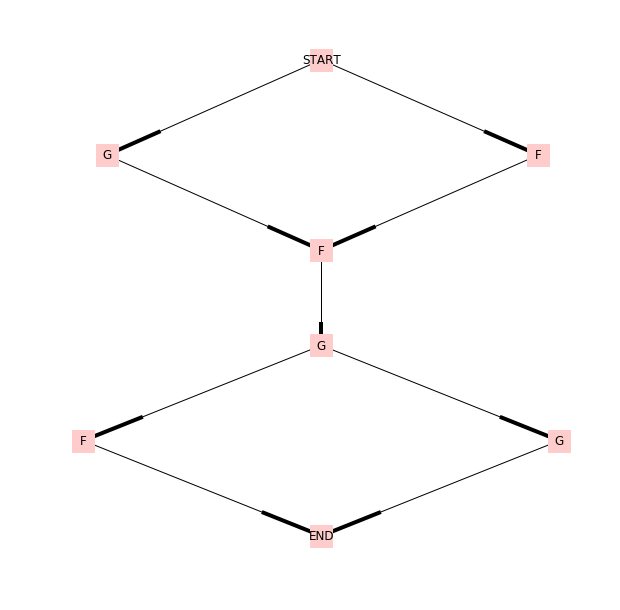

In [3]:
from estnltk.finite_grammar.trees import plot_graph, graph_from_document

document = {'F':[(1,4), (5,10),           (17,19)], 
            'G':[(1,4),         (11, 13), (15,19)]}

graph = graph_from_document(document)
plot_graph(graph)

# PhraseListTagger
## Example 1

In [4]:
from estnltk import Text
text_1 = Text('Patsient lasi jalga, sest vasaku jala suure varba pika \
               painutajalihase kõõluse rebend ajas tal kopsu üle maksa.')
text_1.analyse('morphology')

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [5]:
from estnltk.finite_grammar import PhraseListTagger

phrase_list = [
               ('jalg'),
               ('vasak', 'jalg',),
               ('parem', 'jalg',),
               ('kops',),
               ('vasak', 'kops'),
               ('parem', 'kops'),
               ('kõõlus',),
               ('lihas',),
               ('maks',),
               ('neer',),
               ('parem', 'neer'),
               ('vasak', 'neer'),
               ('varvas',),
               ('suur', 'varvas'),
              ]

def decorator(text, span, phrase):
    return {'match': phrase, 'dfsd':None}

def consistency_checker(text, span, phrase):
    return True

tagger = PhraseListTagger(layer_name='body_parts',
                          input_layer='morph_analysis',
                          input_attribute='lemma',
                          phrase_list=phrase_list,
                          attributes=('match',),
                          decorator=decorator,
                          consistency_checker=consistency_checker,
                          conflict_resolving_strategy= 'MAX')
tagger

In [6]:
tagger.tag(text_1)

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [7]:
text_1['body_parts']

Note that 'maksa' is not tagged. This is because Vabamorf thinks its lemma is 'maksma'.

## Example 2: postprocessing
Suppose that we want to postprocess the layer before adding it to the text object. Here we add an attribute 'latin_term' to the layer.

In [8]:
text = Text('Vasaku jala suure varba pika painutajalihase kõõluse rebend ajas patsiendi kopsu üle maksa.')
text.analyse('morphology')
latin_dict = {('suur', 'varvas'):'hallux', ('kõõlus',):'tendo', ('kops',):'pulmo'}

layer = tagger.tag(text, return_layer=True)
layer.attributes = ('match','latin_term')
for s in layer:
    s.latin_term = latin_dict[s.match]
text['body_parts'] = layer
text['body_parts']

## Example 3

In [9]:
text = Text('Naeris naeris.')
text.analyse('morphology')

Text(text="Naeris naeris.")

Create one more layer of morphological analysis.

In [10]:
from estnltk.taggers import VabamorfTagger
tagger = VabamorfTagger(layer_name='morph_analysis_no_disambiguate',
                        disambiguate=False)
tagger.tag(text)['morph_analysis_no_disambiguate']

In [11]:
from estnltk.resolve_layer_dag import make_resolver

def decorator(text, span, phrase):
    return {'match': phrase}

tagger = PhraseListTagger('test',
                          'morph_analysis_no_disambiguate',
                          'lemma',
                          [
                            ('naerma', 'naerma'),
                            ('naerma', 'naeris'),
                            ('naeris', 'naerma'),
                            ('naeris', 'naeris'),
                          ],
                          attributes=('match',),
                          decorator=decorator,
                          conflict_resolving_strategy='ALL')
tagger.tag(text)
text['test']

# Layer to graph
Here we use the text from Example 3.

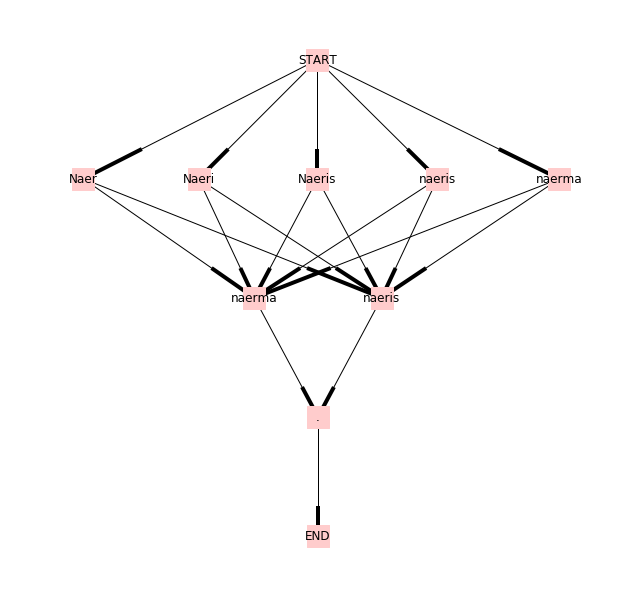

In [12]:
from estnltk.finite_grammar.trees import layer_to_graph_by_attribute
import networkx as nx
from collections import defaultdict
from estnltk.spans import SpanList

g = layer_to_graph_by_attribute(text['morph_analysis_no_disambiguate'], 'lemma')
plot_graph(g)

In [13]:
nodes_list = list(g.nodes)
nodes_list

[N(naerma, (7, 13), 1.00),
 N(END, (inf, inf), 1.00),
 N(naerma, (0, 6), 1.00),
 N(Naer, (0, 6), 1.00),
 N(Naeri, (0, 6), 1.00),
 N(naeris, (7, 13), 1.00),
 N(., (13, 14), 1.00),
 N(Naeris, (0, 6), 1.00),
 N(naeris, (0, 6), 1.00),
 N(START, (-inf, -inf), 1.00)]

In [19]:
print(nodes_list[3])
nodes_list[5].spans

N(Naer, (0, 6), 1.00)


[Span(naeris, {'root_tokens': ('naeris',), 'ending': '0', 'form': 'sg n', 'root': 'naeris', 'clitic': '', 'partofspeech': 'S', 'lemma': 'naeris'}),
 Span(naeris, {'root_tokens': ('naeris',), 'ending': 's', 'form': 'sg in', 'root': 'naeris', 'clitic': '', 'partofspeech': 'S', 'lemma': 'naeris'})]